# Analysis of differential expression across conditions

* Temperature: 10, 18, 25, 34
* Lighting: Dark, Light

__NOTES__:

1. So far I have computed DE among all samples disregarding effect of day cycle. I would need to compute DE between light and dark conditions, as well as DE for temperature for the two independent data sets (light, dark)
2. Regarding the two effects, I could find genes:

Condition | Temp (10 -> 34) 
--- | ---
Light | (+, -) 
Dark | (+, -) 

Hence, would be interesting to cluster genes based on the DE pattern, i.e., those which correlate with temperatur in the same manner under light or dark and those that differ...

3. Need also to establish which condition generates more variance: lighting or temperature?
4. GEMs of marine bacteria: https://www.sciencedirect.com/science/article/pii/S1874778717300508?via%3Dihub#bb0165
5. GEM reconstrution tools: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1769-1
6. Use Clust to cluster genes with significant DE among temperatures with similar patterns: https://github.com/BaselAbujamous/clust 
7. Schurch et al. (2016) recommend DeSeq2 but point that with 3 replicates one should only consider |fold change| > 0.5 (https://rnajournal.cshlp.org/content/22/6/839.full)

References:
* Rsubread: https://academic.oup.com/nar/article/47/8/e47/5345150
* DeSeq2: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
* Clust: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1536-8
* BRENDA: https://academic.oup.com/nar/article/49/D1/D498/5992283
* eQuilibrator: https://academic.oup.com/nar/article/40/D1/D770/2903458

NOTES (Meeting with Laura)
* Repeat analysis only using one technical replicate (T) for T=34. > Don't observe major differences.
* Increase log2-fold-change threshold to 0.5: it doesn't make sense that the greatest differences are found at T=18 > Changes dramatically, only remain DE+ genes in T=10 and T=18.
* Clusters: would be interesting to do the clustering with all genes not just DE... although I have my doubts. > Did it, interestingly I only got two clusters even after changing the tightness parameter.
* Clusters: Laura gave a nice interpretation, C0 -> Genes that are downregulated in cold, C1 -> Heat stress, grows at T=34, C2 -> Genes that are upregulated at the T optimal for growth (T=25), C3 -> Genes that need to be upregulated in cold
* Laura wants for me to estimate transcripts per cell by doing a second alignment with another organism, for certain genes for which they know exactly how much there is, the GBK is in the server (Sulfosomething)
* Laura got similar clusters with Phrocorococcus, could be interesting to do a BRENDA search on this, also there is a GEM for this baterium.
* The focus of this study is on unravelling metabolic adaptations to changes in temperature.

In [1]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from brendapyrser import BRENDA
import Dokdonia_code as Dc
%matplotlib inline

In [14]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


## Normalizing by internal standard
1. Prepared GTF file from GBK and FASTA
2. Aligned and counted reads with Rsubread

In [15]:
# Loading Internal Standard counts and removing genes with low read counts across samples
min_count = 10

IS_counts = pd.read_csv('Data/Laura_Normalization/SulfoStandardsCounts.csv', index_col=0)
IS_counts = IS_counts[IS_counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in IS_counts.columns]
IS_counts.columns = conditions
IS_counts = IS_counts[(IS_counts > min_count).all(1)]
IS_counts.reset_index(level=0, inplace=True)
IS_counts

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,s3_pdhD_v1_1000_Frag,72598,49476,44781,41976,45059,61529,43659,238,38833,...,44528,62015,83731,71613,70473,68516,57863,50533,45087,66020
1,s6_hyp1378_v1_964_Frag,72653,47522,60846,43220,43982,55793,50789,215,41727,...,53412,68243,88206,70797,66017,76033,58339,51977,55047,65414
2,s7_hyp1273_v1_991_Frag,52469,37019,55667,33402,37222,47338,38300,217,34221,...,49129,55926,84796,54971,49270,72528,46602,48531,45793,53807
3,s13_therm_v1_613_Frag,114019,71758,97845,66170,75550,98543,80188,368,68877,...,97668,110083,146095,112836,96878,126030,93214,85357,86459,104693
4,s14_virB_v1_301_Frag,76247,54063,90804,59967,72004,81346,64649,327,59965,...,66344,99487,137419,85065,82237,120758,88558,92649,86015,101281
5,s15_alpha_v1_1504_Frag,33805,23077,17434,20281,20625,37129,21961,152,20046,...,19517,25030,32513,37034,34845,30555,26086,21041,18819,42985


In [16]:
# Load and format standards data
standards_data = pd.read_excel('Data/Laura_Normalization/Standards_Dokdonia.xlsx', index_col=0)
standards_data.reset_index(level=0, inplace=True)
standards_data = standards_data[(standards_data['Standard'].notna()) & (standards_data['Sample ID'].notna())]
standards_data['Standard'] = standards_data['Standard'].apply(lambda s: s.strip())
standards_data['Sample ID'] = standards_data['Sample ID'].apply(lambda s: s.strip())
standards_data.head()

,Sample ID,Standard,Standard reads counts,Standard stock (pg/uL),Volume added (uL),Standard added (pg),Length (bp),MW (g/mol),Avogadro (molec/mol),moleculas/gr,Standard added (copias),Standard ratio,Avg Standard ratio,DesvS ratio,CV
0,L_10_R1,s13_therm_v1_613_Frag,201008.0,25.807806,20.0,516.15611,613.0,208420.0,6.022000e+23,2.889358e+18,1.491360e+09,7419.405196,8361.014907,3315.683084,39.656467
1,L_10_R1,s14_virB_v1_301_Frag,121484.0,14.993974,20.0,299.87948,301.0,102340.0,6.022000e+23,5.884307e+18,1.764583e+09,14525.229550,NaN,NaN,NaN
2,L_10_R1,s15_alpha_v1_1504_Frag,58100.0,14.230661,20.0,284.61321,1504.0,511360.0,6.022000e+23,1.177644e+18,3.351730e+08,5768.898780,NaN,NaN,NaN
3,L_10_R1,s3_pdhD_v1_1000_Frag,124049.0,22.149535,20.0,442.99070,1000.0,340000.0,6.022000e+23,1.771176e+18,7.846147e+08,6325.038529,NaN,NaN,NaN
4,L_10_R1,s6_hyp1378_v1_964_Frag,126235.0,22.246123,20.0,444.92246,964.0,327760.0,6.022000e+23,1.837320e+18,8.174649e+08,6475.739136,NaN,NaN,NaN


In [17]:
# load and format abundance data
abundance_meta = pd.read_excel('Data/Laura_Normalization/Abundancias_Dokdonia.xlsx', index_col=0)
abundance_meta.reset_index(level=0, inplace=True)
abundance_meta = abundance_meta[abundance_meta['Sample'].notna()]
abundance_meta['Sample'] = abundance_meta['Sample'].apply(lambda s: s.strip())
abundance_meta.head()

,Sample,Avg_Standard_ratio,Abundancia_cells_mL,Vol_filtered_mL,Total_cell_abundance
0,L_10_R1,8361.014907,1.521921e+06,500,7.609607e+08
1,L_10_R2,25169.662201,1.086850e+06,500,5.434251e+08
2,L_10_R3,21891.978025,1.219073e+06,500,6.095364e+08
3,D_10_R1,14032.230064,1.135166e+06,490,5.562311e+08
4,D_10_R2,20613.230047,1.170827e+06,500,5.854134e+08


In [18]:
# Compute Transcripts/Cell (Would check how replicate variance changed after transformation)
avg_st_ratios = Dc.getAverageStandardRatio(IS_counts, standards_data)
n_counts = Dc.getTranscriptsPerCell(counts, avg_st_ratios, abundance_meta)
# n_counts.to_csv('Data/Dokdonia_transcripts_cell.csv')
n_counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R2,D_25_R3,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,0.327274,0.402326,0.319319,1.504600,2.588597,1.816263,NaN,1.252534,1.377925,...,1.024204,0.600671,NaN,1.162753,1.091035,1.497091,0.894585,0.969526,1.271870,1.474154
1,MED134_07384,0.039279,0.054754,0.037400,0.204387,0.370730,0.247459,NaN,0.174478,0.189857,...,0.161554,0.075332,NaN,0.159744,0.144771,0.215060,0.121708,0.148669,0.199779,0.199276
2,MED134_07379,0.085773,0.116867,0.078872,0.354630,0.668159,0.422425,NaN,0.293002,0.369985,...,0.288264,0.134483,NaN,0.267931,0.235775,0.344913,0.229589,0.238353,0.336011,0.352442
3,MED134_07374,0.050127,0.074789,0.033833,0.172402,0.318904,0.192060,NaN,0.128314,0.152053,...,0.113289,0.064169,NaN,0.105710,0.093986,0.141055,0.093785,0.096881,0.122292,0.135680
4,MED134_07369,0.052649,0.070775,0.050870,0.185422,0.322032,0.198658,NaN,0.133732,0.137702,...,0.160357,0.086695,NaN,0.109218,0.108735,0.152055,0.124460,0.111494,0.126488,0.131270


In [19]:
# Parsing GBK file and KEGG pathways
with open('Data/Function_Annotations/kegg_pathways.json') as json_file:
    kegg_pathways = json.load(json_file)['children']
kegg_dict = Dc.assignSystemsToEnzymes(kegg_pathways)
    
kegg_dict = Dc.assignSystemsToEnzymes(kegg_pathways)
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')
gbk.meta

{'organism': ['Dokdonia sp. MED134'],
 'mol_type': ['genomic DNA'],
 'strain': ['MED134'],
 'isolation_source': ['collected at a depth of 1 meter; isolated by plating on solid media'],
 'db_xref': ['taxon:313590'],
 'country': ['Mediterranean Sea']}

## Analysis of differential expression

We compare expression across temperature and between light and dark conditions.

## DE light vs dark across temperatures

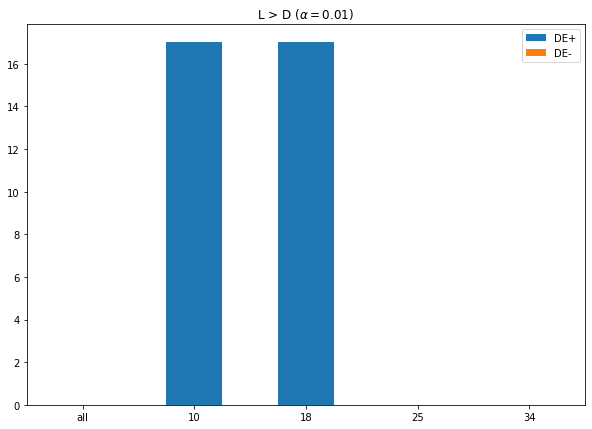

In [20]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = Dc.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = Dc.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L > D ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [22]:
# L > D, T = 18 Proteins
res = L_D_res['18']
np.unique([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in res[res.log2FoldChange > 0].index])

array(['ABC1 family protein', 'ATP-dependent protease La (LON)',
       'DNA photolyase/cryptochrome, animal cryptochrome and (6-4) photolyase subfamily',
       'GTP cyclohydrolase I', 'cryptochrome, DASH family',
       'deoxyribodipyrimidine photolyase-related protein',
       'hypothetical protein', 'peptide-methionine (S)-S-oxide reductase',
       'phytoene dehydrogenase', 'putative cell adhesion protein',
       'rhodopsin', 'sensor of blue-light using FAD',
       'short chain dehydrogenase'], dtype='<U79')

## DE on multiple comparisons across temperatures
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

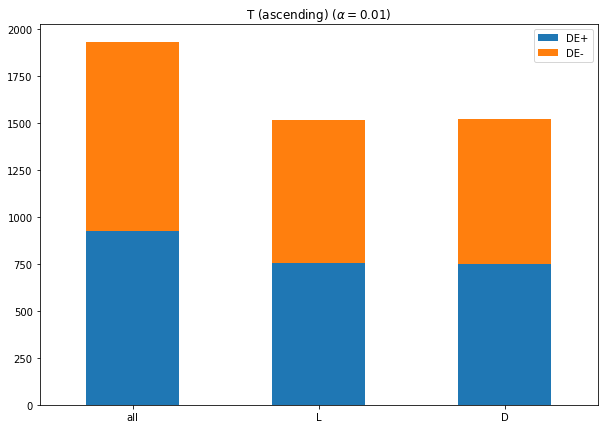

In [23]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = Dc.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = Dc.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')
    
# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

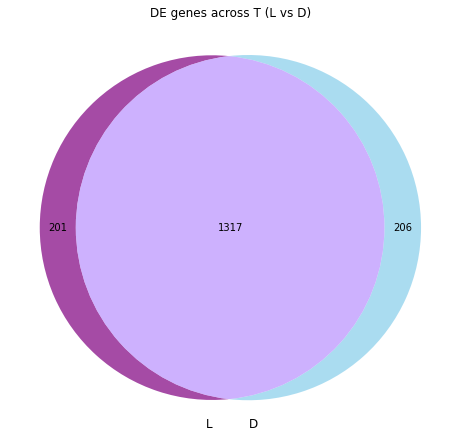

In [24]:
# Plot L-D Venn diagram
plt.figure(figsize=(8, 8))
set1 = set(T_res['L'].index)
set2 = set(T_res['D'].index)
Light_specific_DE_genes = set1 - set2
Dark_specific_DE_genes = set2 - set1
venn2([set1, set2], ('L', 'D'),
      set_colors=('purple', 'skyblue'), alpha = 0.7)
plt.title('DE genes across T (L vs D)')
plt.show()

## Which pathways are represented in across-temperature-DE genes specific of light and dark conditions?

In [9]:
light_DE = [(gbk.getGeneInfo(gene_id)['EC_number'][0], gbk.getGeneInfo(gene_id)['product'][0])
            for gene_id in Light_specific_DE_genes if gbk.has_EC_number(gene_id)]
dark_DE = [(gbk.getGeneInfo(gene_id)['EC_number'][0], gbk.getGeneInfo(gene_id)['product'][0])
            for gene_id in Dark_specific_DE_genes if gbk.has_EC_number(gene_id)]

In [38]:
Dc.getCounts([kegg_dict[ec]['system'] for ec, name in dark_DE if ec in kegg_dict.keys()])

{'09101 Carbohydrate metabolism': 10,
 '09105 Amino acid metabolism': 7,
 '09108 Metabolism of cofactors and vitamins': 5,
 '09104 Nucleotide metabolism': 3,
 '09132 Signal transduction': 3,
 '09107 Glycan biosynthesis and metabolism': 2,
 '09191 Unclassified: metabolism': 2,
 '09106 Metabolism of other amino acids': 1,
 '09109 Metabolism of terpenoids and polyketides': 1,
 '09124 Replication and repair': 1,
 '09174 Infectious disease: parasitic': 1}

In [39]:
Dc.getCounts([kegg_dict[ec]['system'] for ec, name in light_DE if ec in kegg_dict.keys()])

{'09104 Nucleotide metabolism': 4,
 '09101 Carbohydrate metabolism': 3,
 '09132 Signal transduction': 3,
 '09103 Lipid metabolism': 2,
 '09106 Metabolism of other amino acids': 2,
 '09107 Glycan biosynthesis and metabolism': 2,
 '09108 Metabolism of cofactors and vitamins': 2,
 '09122 Translation': 2,
 '09124 Replication and repair': 2,
 '09105 Amino acid metabolism': 1,
 '09191 Unclassified: metabolism': 1}

## Gene clustering based on expression pattern
We will employ _clust_ to cluster significant DE genes into groups of similar expression pattern across conditions. Let's first generate the tsv file required by _Clust_

__CLUST__:

"Clust is designed to address this problem by extracting the largest and least dispersed set of clusters whose profiles are distinct and exclude those genes that do not belong to these clusters. That is, to identify and extract the complete set of genes that are exhibiting coordinate behavior in the experimental series under consideration."

In [25]:
tpm = pd.read_csv('Data/tpm_counts.csv', index_col=0)
tpm = tpm[tpm.filter(regex='^[^T]+$').columns]
tpm.index.name = 'ID'
tpm.columns = conditions

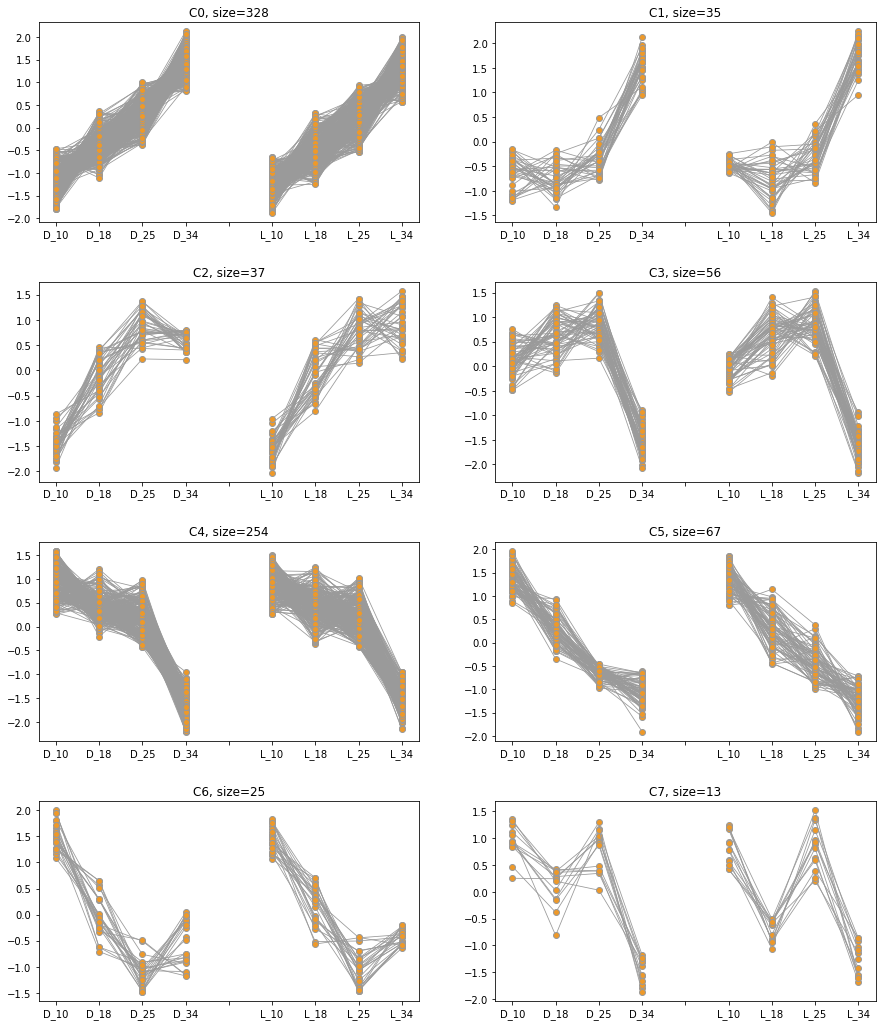

In [57]:
# Cluster only DE genes across temperatures
res_id = 'CLUSTER_DE_GENES'
gene_ids = T_res['all'].index
workdir = os.path.join(os.getcwd(),'Results')
DE_TPM = tpm[tpm.index.isin(gene_ids)]
clusters = Dc.getGeneClusters(DE_TPM, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=5)

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

plotClusters(pdata, clusters)

## On clusters
Clusters are very similar between light and dark conditions, unlike Prochlorococcus. This makes sense, since Dokdonia is not photosynthetic. Also, the differences in DE genes between light and dark were minimal.

# Identifying pathways
Currently, I only have pathway information for genes with associated EC number. Let's get all the genes with available EC number in each cluster.

In [16]:
# Add EggNOG function data to genes (prepare fasta input file)
from Bio import SeqIO

def getEggNOGInputFile(gbk_file):
    "First line cannot be blank"
    with open('eggNOG_Input.fasta', 'a') as file:
        for rec in SeqIO.parse(gbk_file, "genbank"):
            for feature in rec.features:
                if feature.type == 'CDS':
                    gene = feature.qualifiers["locus_tag"][0].replace("'", "")
                    aas = feature.qualifiers["translation"][0].replace("'", "")
                    file.write(f'\n>{gene}\n{aas}')

getEggNOGInputFile('Data/DokdoniaMED134.gbk')

In [13]:
# Read eggNOG - Mapper (http://eggnog-mapper.embl.de/) results 
eggNOG = pd.read_excel('Data/Function_Annotations/result_eggnogMapper.xlsx', header=4)
len(eggNOG['EC number'].dropna())

903

In [58]:
# Read DeepGOPlus result
deepGO = pd.read_csv('Data/Function_Annotations/result_deepgoplus.tsv', sep='\t')
deepGO.head()

ParserError: Error tokenizing data. C error: Expected 33 fields in line 3, saw 82


In [13]:
ec_genes = {}
for cluster_id, cluster in clusters.items():
    ec_genes[cluster_id] = [(gbk.getGeneInfo(gene_id)['EC_number'][0], gbk.getGeneInfo(gene_id)['product'][0])
                            for gene_id in cluster if gbk.has_EC_number(gene_id)]

In [35]:
def getRankedSystems(EC_numbers, system_type='system'):
    systems = []
    for ec in EC_numbers:
        try:
            systems.append(kegg_dict[ec][system_type])
        except:
            pass
    return Dc.getCounts(systems)

data = getRankedSystems([tup[0] for tup in ec_genes['C1']], system_type='system')
data

{'09104 Nucleotide metabolism': 1,
 '09109 Metabolism of terpenoids and polyketides': 1}

# Notes on possible errors in annotation
1. MED134_07089: The EC number corresponds to [adenylate cyclase](https://www.brenda-enzymes.org/enzyme.php?ecno=4.6.1.1) however protein [EAQ40501.1](https://string-db.org/network/313590.MED134_07089) isn't annotated, and the product description is "sensor of blue light using FAD". After searching for EC number ('4.6.1.1') I found another gene: MED134_03369, which seems to be the true adenylate cyclase!.